In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt, numpy as np6
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.cluster import AgglomerativeClustering
# from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(15)



## Pre-processing

In [2]:
# Load data
cust_df = pd.read_csv("data/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(cust_df))
cust_df.head()



Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# reveal some feature info
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
cust_df = cust_df.dropna()

In [5]:
# Find unique values 
print("Unique categories in 'Marital_Status':\n", cust_df["Marital_Status"].value_counts(), "\n")
print("Unique categories in 'Education':\n", cust_df["Education"].value_counts())

Unique categories in 'Marital_Status':
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Unique categories in 'Education':
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [6]:
# Feature Engineering
# Creating an age feature
cust_df['Age'] = 2021-cust_df['Year_Birth']

# Create 'children' that counts minors in a household
cust_df['Children']=cust_df['Kidhome']+cust_df['Teenhome']

# Create Parent bool
cust_df["Is_Parent"] = np.where(cust_df.Children> 0, 1, 0)

# Creating total spent feature
cust_df['Spent'] = cust_df['MntWines']+ cust_df['MntFruits']+ cust_df['MntMeatProducts']+cust_df['MntFishProducts']+ cust_df['MntSweetProducts']+ cust_df['MntGoldProds']
    
# Creating living_status feature from marital_status col
cust_df['Living_status']=cust_df['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone',
                                                          'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 
                                                          'Single':'Alone',})
# demystify Edu col
cust_df["Education"]=cust_df["Education"].replace(
                    {"Basic":"Undergrad","2n Cycle":"Undergrad", "Graduation":"Grad", "Master":"Postgrad", "PhD":"Postgrad"})

# Simplify spending categories
cust_df=cust_df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":
                                "Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

cust_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Children,Is_Parent,Spent,Living_status
0,5524,1957,Grad,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,64,0,0,1617,Alone
1,2174,1954,Grad,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,67,2,1,27,Alone
2,4141,1965,Grad,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,56,0,0,776,Partner
3,6182,1984,Grad,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,37,1,1,53,Partner
4,5324,1981,Postgrad,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,40,1,1,422,Partner


In [7]:
# Find oldest/newest records
cust_df["Dt_Customer"] = pd.to_datetime(cust_df["Dt_Customer"])
dates = []
for i in cust_df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
    
# print min/max
print("The newest customer's enrollment date is:",max(dates))
print("The oldest customer's enrollment date is:",min(dates))



The newest customer's enrollment date is: 2014-12-06
The oldest customer's enrollment date is: 2012-01-08


In [8]:
# Created a col 'Customer_For_x_days'
days = []
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(delta)
cust_df["Customer_For_x_days"] = days
cust_df["Customer_For_x_days"] = pd.to_numeric(cust_df["Customer_For_x_days"], errors="coerce")


In [9]:
# Drop outliers: cap on Age and income. 
cust_df = cust_df[(cust_df["Age"]<90)]
cust_df = cust_df[(cust_df["Income"]<600000)]
print("Remaining datapoints:", len(cust_df))

Remaining datapoints: 2212


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

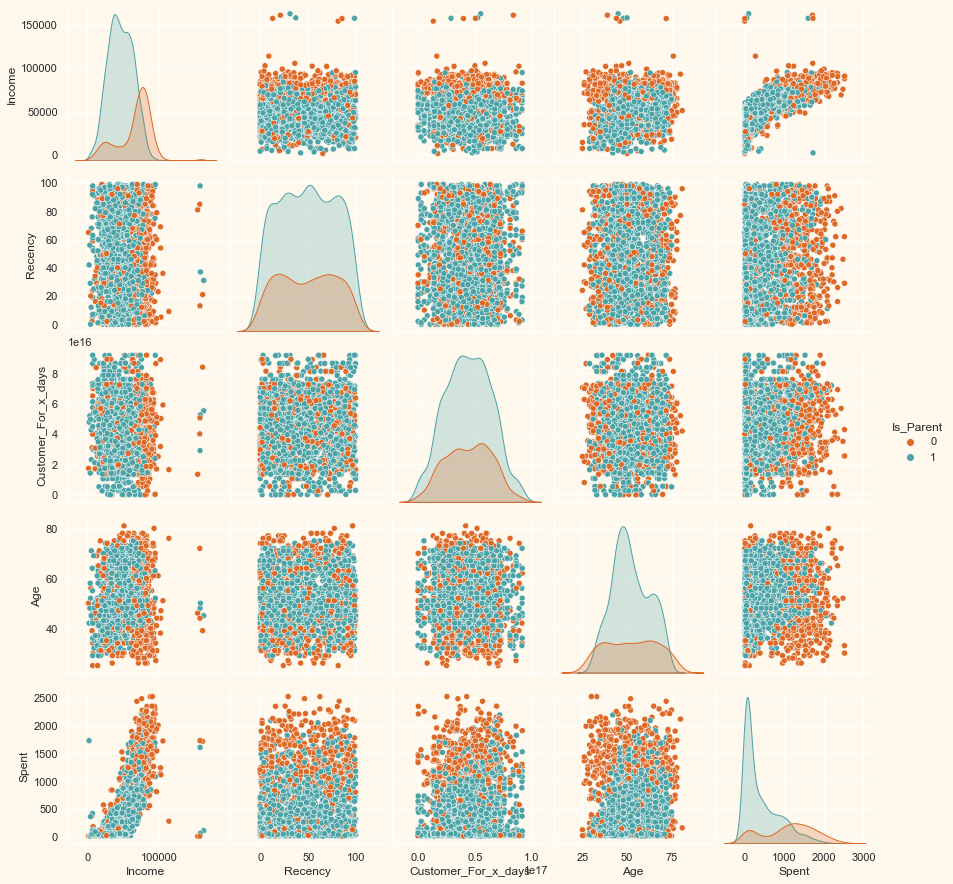

In [10]:
# set up colormap for future, test with a pairplot
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#a85322", "#749ba1", "#e6b791", "#c0a8e0", "#d68da2", "#1fd5db"]
cmap = colors.ListedColormap(["#a85322", "#749ba1", "#e6b791", "#c0a8e0", "#d68da2", "#4ba3a6"])

To_Plot = [ "Income", "Recency", "Customer_For_x_days", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
# Set Hue to 'is_parent'
sns.pairplot(cust_df[To_Plot], hue= "Is_Parent",palette= (["#de6926","#4ba3a6"]))
plt.show()

<AxesSubplot:>

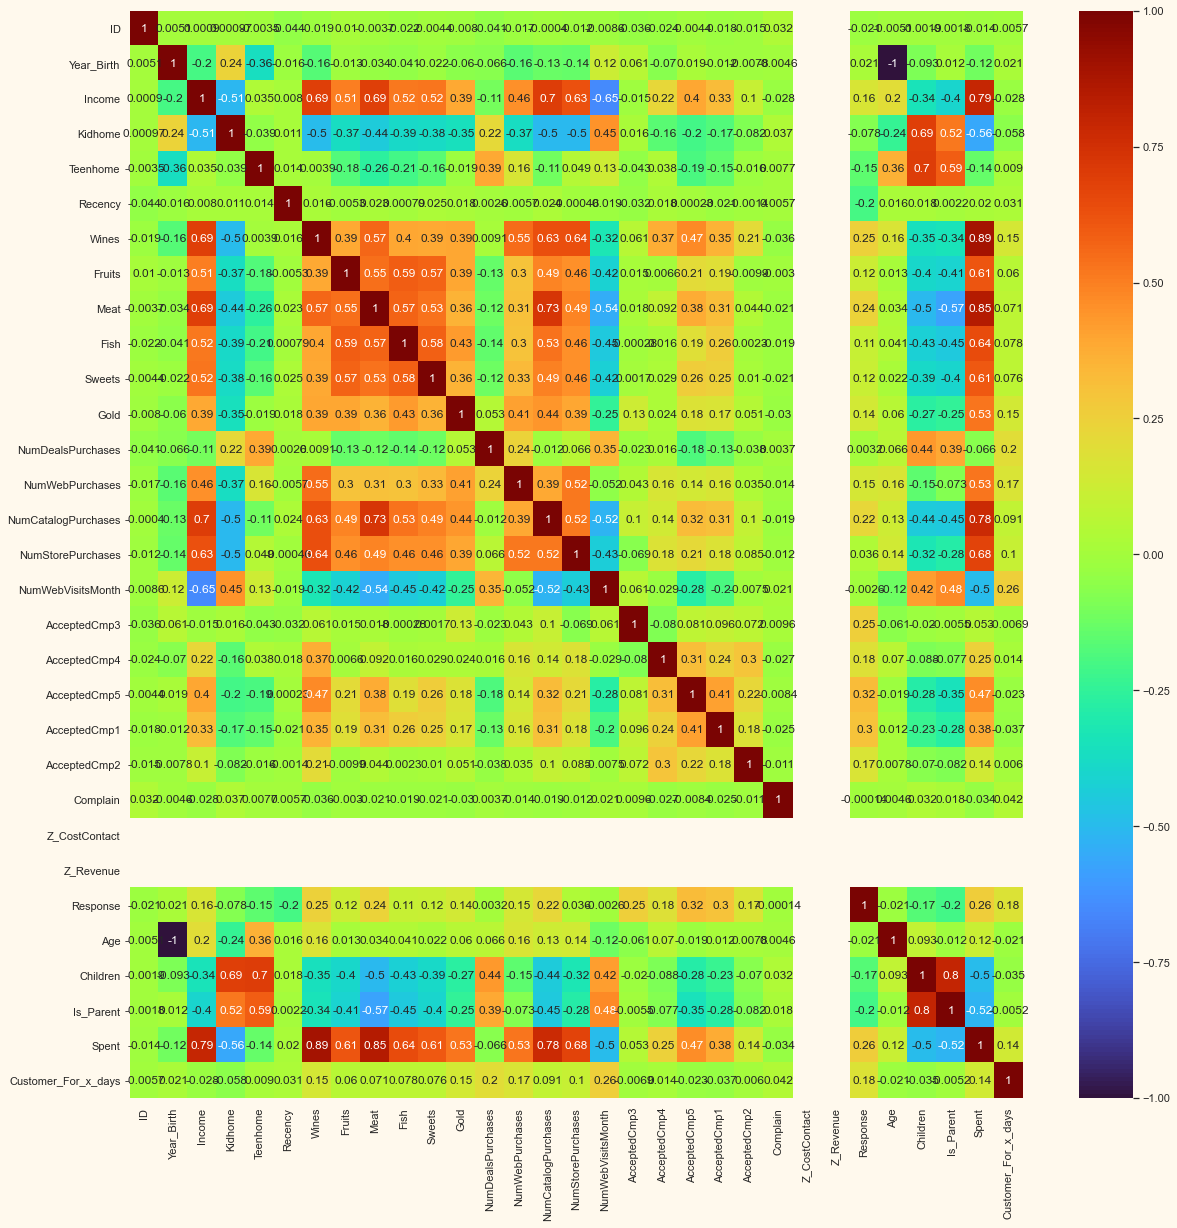

In [11]:
# Create a heatmap
corrmat= cust_df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='turbo', center=0)

## Scaling and Dimensionality Reduction

In [12]:
# Create dummy variables for text features with get_dummies
cust_dummies= pd.get_dummies(cust_df, columns=['Education'])
cust_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,...,Complain,Z_CostContact,Z_Revenue,Response,Age,Children,Is_Parent,Spent,Living_status,Customer_For_x_days
0,5524,1957,Grad,Single,58138.0,0,0,2012-04-09,58,635,...,0,3,11,1,64,0,0,1617,Alone,83894400000000000
1,2174,1954,Grad,Single,46344.0,1,1,2014-08-03,38,11,...,0,3,11,0,67,2,1,27,Alone,10800000000000000
2,4141,1965,Grad,Together,71613.0,0,0,2013-08-21,26,426,...,0,3,11,0,56,0,0,776,Partner,40780800000000000
3,6182,1984,Grad,Together,26646.0,1,0,2014-10-02,26,11,...,0,3,11,0,37,1,1,53,Partner,5616000000000000
4,5324,1981,Postgrad,Married,58293.0,1,0,2014-01-19,94,173,...,0,3,11,0,40,1,1,422,Partner,27734400000000000


In [15]:
#Get list of categorical variables
s = (cust_df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Marital_Status', 'Living_status']


In [16]:
# Create dummy variables for text features with get_dummies
cust_dummies = pd.get_dummies(cust_df, columns=['Education', 'Marital_Status', 'Living_status'])
cust_dummies.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,Fruits,Meat,...,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Living_status_Alone,Living_status_Partner
0,5524,1957,58138.0,0,0,2012-04-09,58,635,88,546,...,0,0,0,0,1,0,0,0,1,0
1,2174,1954,46344.0,1,1,2014-08-03,38,11,1,6,...,0,0,0,0,1,0,0,0,1,0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,0,0,0,0,0,1,0,0,0,1
3,6182,1984,26646.0,1,0,2014-10-02,26,11,4,20,...,0,0,0,0,0,1,0,0,0,1
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,0,0,0,1,0,0,0,0,0,1


In [25]:
# Remove superfluous cols
# Create a copy of data
copied_df = cust_dummies.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
copied_df = copied_df.drop(cols_del, axis=1)
copied_df.head()
# Scale the data
cust_scaled = StandardScaler().fit_transform(copied_df)
# print(cust_scaled[0:1])

TypeError: invalid type promotion